In [1]:
import sys
# load standard python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import ElasticNet

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

from modules.jet_augs import crop_jets, remove_jet_and_rescale_pT
from modules.neural_net import create_and_run_nn

seed = 5

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.empty_cache()


from numba import cuda 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = cuda.get_current_device()
device.reset()


In [2]:
# More parameters / computing setup

# set the number of threads that pytorch will use
torch.set_num_threads(2)

exp_id = "dim_scan_22_02_19/const_rep"+"_seed_"+str(seed)+"/"

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "device: " + str( device ), flush=True)

# set up results directory
base_dir = "/global/home/users/rrmastandrea/MJetCLR/"  # change this to your working directory
expt_dir = base_dir + "projects/rep_learning/experiments/" + exp_id + "/"

#check if experiment alreadyexists
if os.path.isdir(expt_dir):
    print("ERROR: experiment already exists, don't want to overwrite it by mistake")
    pass
else:
    os.makedirs(expt_dir)

print("experiment: "+str(exp_id) , flush=True)


device: cuda
experiment: dim_scan_22_02_19/const_rep_seed_5/


In [3]:
path_to_save_dir = "/global/home/users/rrmastandrea/training_data_vf/"
BC_dir = "nBC_sig_85000_nBC_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/"
TEST_dir = "STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/"

grading = 50
n_constits_max = 50
n_jets = 2


path_to_BC = path_to_save_dir+BC_dir
print(path_to_BC)

path_to_test = path_to_save_dir+TEST_dir
print(path_to_test)


data_train = np.load(path_to_BC+"data_train.npy")
labels_train = np.load(path_to_BC+"labels_train.npy")
data_val = np.load(path_to_BC+"data_val.npy")
labels_val = np.load(path_to_BC+"labels_val.npy")
data_test_f = np.load(path_to_test+"data.npy")
labels_test_f = np.load(path_to_test+"labels.npy")

# print data dimensions
print( "BC training data shape: " + str( data_train.shape ), flush=True)
print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
print( "BC val data shape: " + str( data_val.shape ), flush=True)
print( "BC val labels shape: " + str( labels_val.shape ), flush=True)
print( "BC test data shape: " + str( data_test_f.shape ), flush=True)
print( "BC test labels shape: " + str( labels_test_f.shape ), flush=True)
print()
print()


cropped_train = remove_jet_and_rescale_pT(data_train, n_jets)
cropped_val = remove_jet_and_rescale_pT(data_val, n_jets)
cropped_test = remove_jet_and_rescale_pT(data_test_f, n_jets)

print(cropped_train.shape)
print(cropped_val.shape)
print(cropped_test.shape)

# Plot num constituents

def get_num_constits(dataset):
    consits_list = []
    for collision in dataset:
        pts = collision[0,:]

        pads = np.where(pts==0)
        consits_list.append(dataset.shape[2]-len(pads[0]))
        
    return consits_list
        

/global/home/users/rrmastandrea/training_data_vf/nBC_sig_85000_nBC_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/training_data_vf/STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/
BC training data shape: (119000, 3, 102)
BC training labels shape: (119000,)
BC val data shape: (51000, 3, 102)
BC val labels shape: (51000,)
BC test data shape: (20000, 3, 102)
BC test labels shape: (20000,)


(119000, 3, 100)
(51000, 3, 100)
(20000, 3, 100)


# Run final LCT, NN on the constituent representations

(119000, 300)
(20000, 300)
Doing a LCT...
0.88300888


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


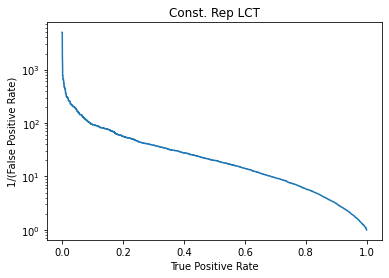

LCT data saved



In [4]:
# with the constituent set (pt, eta, phi)

constit_num = 2*grading


lct_train = np.reshape(cropped_train,(cropped_train.shape[0],3*constit_num))
lct_test = np.reshape(cropped_test,(cropped_test.shape[0],3*constit_num))

print(lct_train.shape)
print(lct_test.shape)


print("Doing a LCT...")
#lc = LinearRegression()
lc = Ridge(alpha = 1)
lc.fit(lct_train, labels_train)
# make the prediction
predictions = lc.predict(lct_test)
fpr, tpr, _ = roc_curve(labels_test_f, predictions)

auc = roc_auc_score(labels_test_f, predictions)

print(auc)

plt.figure()
plt.plot(tpr, 1.0/fpr)
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.title("Const. Rep LCT")
plt.show()


np.save( expt_dir+"const_rep_lct_fpr_"+str(constit_num)+".npy", fpr )
np.save( expt_dir+"const_rep_lct_tpr_"+str(constit_num)+".npy", tpr )
print("LCT data saved")


print()



Doing a NN...
Starting training...


 22%|██▏       | 260/1200 [02:37<09:30,  1.65it/s]


INFO: Early stopping
Finished Training


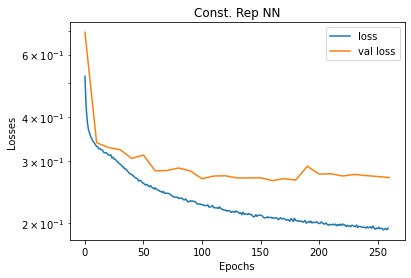

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


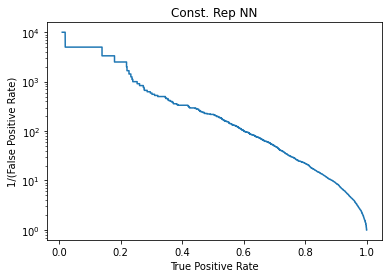

Accuracy of the network: 89 %
ROC AUC: 0.958246785


In [5]:
print("Doing a NN...")
num_epochs_nn = 1200
batch_size_nn = 400
update_epochs_nn = 10
input_shape = 3*constit_num
#update_epochs_nn = 20
lr_nn = 0.001



performance_stats_nn = create_and_run_nn(device, input_shape, num_epochs_nn, batch_size_nn, update_epochs_nn,lr_nn, 
                                         cropped_train, labels_train, 
                      cropped_val, labels_val,
                      cropped_test, labels_test_f, True)

# Plot the output losses   
plt.figure()
plt.plot(performance_stats_nn["epochs"],performance_stats_nn["losses"], label = "loss")
plt.plot(performance_stats_nn["val_epochs"],performance_stats_nn["val_losses"], label = "val loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.yscale("log")
plt.legend()
plt.title("Const. Rep NN")
plt.show()

plt.figure()
plt.plot(performance_stats_nn["tpr"], 1.0/performance_stats_nn["fpr"])
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.title("Const. Rep NN")
plt.show()

np.save( expt_dir+"const_rep_nn_tpr_"+str(constit_num)+".npy", performance_stats_nn["tpr"] )
np.save( expt_dir+"const_rep_nn_fpr_"+str(constit_num)+".npy", performance_stats_nn["fpr"] )

print("Accuracy of the network: %d %%" % (100.00 *performance_stats_nn["acc"]))
print("ROC AUC:", performance_stats_nn["auc"])

